In [1]:
from __future__ import division, print_function, absolute_import
from IPython.display import display # Allows the use of display() for DataFrames
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def tokenize_str(string):
    '''
    Tokenization/string cleaning
    
    '''
    string = re.sub(r"[^A-Za-z0-9()[],?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\’s", " \'s", string)
    string = re.sub(r"\'m", " am", string)
    string = re.sub(r"\'ve", " have", string)
    string = re.sub(r"can\'t", " cannot", string)
    string = re.sub(r"n\'t", " not", string)
    string = re.sub(r"\'re", " are", string)
    string = re.sub(r"\'d", " had", string)
    string = re.sub(r"\'ll", " will", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"[...]", " ", string)
    string = re.sub(r"/", " or ", string)
    string = re.sub(r"-", " ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

def load_data_and_preprocess(filename):
    '''
    Read csv file into a DataFrame and tokenize Q1 and Q2 strings
    '''
    df = pd.read_csv(filename)
    print(filename + " loaded. Preprocessing...")
    df["q1"] = df["question1"].apply(lambda row: tokenize_str(str(row)))
    df["q2"] = df["question2"].apply(lambda row: tokenize_str(str(row)))
    print("Preprocess done!")
    return df

df_train = load_data_and_preprocess("train.csv")

train.csv loaded. Preprocessing...
Preprocess done!


In [3]:
# Inspect several samples of preprocessed text
a = 80
for i in range(a,a+10):
    print(i, df_train["q1"][i])
    print(i, df_train["q2"][i])
    print("")

80 when will the bjp government strip all the muslims and the christians of the indian citizenship and put them on boats like the rohingya 's of burma \?
80 why india does not apply the "burma rohingya model" to deport illegal bangladeshis \?

81 what is the right etiquette for wishing a jehovah witness happy birthday \?
81 how important is it to be the first person to wish someone a happy birthday \?

82 if someone wants to open a commercial fm radio station in any city of india , how much does it cost and what is the procedure \?
82 i want to make a travel commercial or clip video hd , for india and new zealand how much will it cost \?

83 why do swiss despise asians \?
83 why do technical employees despise sales people so much \?

84 what are some of the high salary income jobs in the field of biotechnology \?
84 what are some high paying jobs for a fresher with an m tech in biotechnology \?

85 how can i increase my height after 21 also \?
85 can height increase after 25 \?

86 wha

In [4]:
# Merge Q1 and Q2 as one feature
df_train["merged"] = df_train["q1"] + " " + df_train["q2"]

print(df_train["merged"][0])

what is the step by step guide to invest in share market in india \? what is the step by step guide to invest in share market \?


In [5]:
# Split into stratified training and validation set
from sklearn.model_selection import train_test_split

X = df_train
y = df_train["is_duplicate"]

X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.05, 
    random_state=42)

# Drop all columns except "merged" for X_val as it is the feature
# We keep all columns in X_train as we want to use those to oversample later
X_val = X_val["merged"]

# Convert the validation set labels to a list of either 0 (not duplicate) or 1 (duplicates)
y_val = y_val.values.tolist()

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(len(y_val))

(384075, 9)
(20215,)
(384075,)
20215


In [6]:
from collections import Counter

print(y_train.value_counts(normalize=True))

c = Counter(y_val)
print(c, float(c[1])/(c[0] + c[1]))

0    0.630822
1    0.369178
Name: is_duplicate, dtype: float64
Counter({0: 12744, 1: 7471}) 0.369577046747


In [7]:
# pos / pos + neg = 16.5%
pct = 16.5
pos_class = (pct * c[0] / (100 - pct))
pos_class_amt = int(np.round(pos_class, 0))
print("Pos class needs to be: " +
      str(pos_class_amt) + " to balance to " + str(pct) + " % duplicates.")

Pos class needs to be: 2518 to balance to 16.5 % duplicates.


In [8]:
# Undersample the positive class in the validation set
def undersample(features, labels, pos_act, pos_needed):
    cnt = 0
    ind = []
    for i, (feat, label) in enumerate(zip(features, labels)):
        if label == 1 and cnt < (pos_act - pos_needed):
            ind.append(i)
            cnt += 1

    features = features.drop(features.index[ind])
    for i in sorted(ind, reverse=True):
        del labels[i]

    print(len(ind))     
    print(len(features), len(labels))

    r = Counter(labels)
    print(r, float(r[1])/(r[0] + r[1]))
    
    return features, labels

X_val, y_val = undersample(X_val, y_val, c[1], pos_class_amt)

4953
15262 15262
Counter({0: 12744, 1: 2518}) 0.164984929891


In [9]:
# Random oversampling

df_pos = X_train[X_train["is_duplicate"] == 1]
df_neg = X_train[X_train["is_duplicate"] == 0]

print("Total positive pair examples: ", len(df_pos))
print("Total negative pair examples: ", len(df_neg))

def pos_neg_stats(df_pos, df_neg, pct):
    '''
    Calculates stats on class imbalance
    '''
    # Pos / Pos + Neg * 100
    pos_neg_ratio = float(len(df_pos)) / (len(df_pos) + len(df_neg)) * 100
    print("Percentage duplicates in dataset: " + str(np.round(pos_neg_ratio, 2)) + " %")

    # Pos / Pos + Neg = 16.5%, then: Neg = Pos * 100 / 16.5 - Pos
    neg_class = (len(df_pos) * 100 / pct) - len(df_pos)
    neg_class_amt = int(np.round(neg_class, 0))
    print("Neg class needs to be: " +
          str(neg_class_amt) + " to balance to " + str(pct) + " % duplicates.")
    
    return neg_class_amt

def random_oversample(pos, neg, pct):
    '''
    Oversamples majority class by an amount
    '''
    # Gets a random sample of all rows (frac=1) i.e. shuffling the entire dataset
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df = pd.DataFrame()
    
    df["q1"] = pos["q1"]
    df["q2"] = neg["q2"]
    #print(len(df))
    
    df2 = pd.DataFrame()
    df2["q1"] = pos["q2"]
    df2["q2"] = neg["q1"]
    #print(len(df2))
    
    df = df.append(df2)
    
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df3 = pd.DataFrame()
    df3["q1"] = neg["q2"]
    df3["q2"] = neg["q1"]
    #print(len(df3))
    
    df = df.append(df3)
    
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df4 = pd.DataFrame()
    df4["q1"] = pos["q2"]
    df4["q2"] = neg["q2"]
    #print(len(df4))
    
    df = df.append(df4)
    
    pos = pos.sample(frac=1).reset_index(drop=True)
    neg = neg.sample(frac=1).reset_index(drop=True)
    
    df5 = pd.DataFrame()
    df5["q1"] = pos["q1"]
    df5["q2"] = neg["q1"]
    #print(len(df5))
    
    df = df.append(df5)
    df = df.reset_index(drop=True)
    print("Total oversampled examples to choose from: ", len(df))
    
    # Randomly select a subset of the oversampled examples 
    # to fit the required percentage duplicates
    df_sample_ind = np.random.choice(
        df.index.values, 
        size=pos_neg_stats(pos, neg, pct), 
        replace=False)
    df_sample = df.loc[df_sample_ind]
    df_sample = df_sample.reset_index(drop=True)
    df_sample["is_duplicate"] = 0 
    
    # Retain all examples in positive class
    df_pos_all = pos[["q1", "q2", "is_duplicate"]].copy()
    df_sample = pd.concat([df_sample, df_pos_all])
    # Reshuffle dataset one last time
    df_sample = df_sample.sample(frac=1).reset_index(drop=True)
    
    print("Total examples in rebalanced dataset: ", len(df_sample))
    
    # Pos / Pos + Neg * 100
    pos_neg_ratio = float(len(pos)) / (len(df_sample)) * 100
    print("Percentage duplicates in rebalanced dataset: " + str(np.round(pos_neg_ratio, 2)) + " %")
    
    display(df_sample.head())
    display(df_sample.tail())
    display(df_sample[["q1", "q2"]].describe())
    
    return df_sample
    
#717553
df_sample = random_oversample(df_pos, df_neg, 16.5)

Total positive pair examples:  141792
Total negative pair examples:  242283
Total oversampled examples to choose from:  809451
Percentage duplicates in dataset: 36.92 %
Neg class needs to be: 717553 to balance to 16.5 % duplicates.
Total examples in rebalanced dataset:  859345
Percentage duplicates in rebalanced dataset: 16.5 %


,q1,q2,is_duplicate
0,what is difference between anti matter and dar...,how do atheists view marriage \?,0
1,where can i get very friendly assistance in sy...,which city is better to live in: vancouver or ...,0
2,what are the best dieting tips \?,what are good diet tips \?,1
3,what is maturity in general \?,how much does an ips officer get monthly \?,0
4,was charlie chaplin a gypsy \?,was charlie chaplin of angloromani or romani o...,1


,q1,q2,is_duplicate
859340,"if you were granted one wish , what would you ...",why is turkey fighting the kurds \?,0
859341,why do people believe in flat earth \?,was jimi hendrix father really part cherokee i...,0
859342,why do pizzas have a plastic table in their ce...,i am a pizza hut delivery driver what are some...,0
859343,i want to share my feelings as i can find no o...,what should i do if my car runs out of gas \?,0
859344,what are the best ways to get rid of mouth sor...,"i am a 20 year old guy and 1 65m \( 5""4 ft \) ...",0


,q1,q2
count,859345,859345
unique,320629,418827
top,how do i lose weight \?,what are the best ways to lose weight \?
freq,251,122


In [10]:
print(df_sample['is_duplicate'].value_counts(normalize=True))

0    0.835
1    0.165
Name: is_duplicate, dtype: float64


In [11]:
# Merge Q1 and Q2 as one feature
df_sample["merged"] = df_sample["q1"] + " " + df_sample["q2"]

# Set feature and value
X_train_sample = df_sample["merged"]

# Convert training set labels to 0 or 1
y_train_sample = df_sample["is_duplicate"].values.tolist()

print(len(X_train_sample))
print(len(y_train_sample))

859345
859345


seq length stats: 
Max:  297
Min:  2

Q1:  18.0
Mean:  24.6622231471
Q3:  29.0
IQR:  11.0
Outlier range: < 1.5 and > 45.5


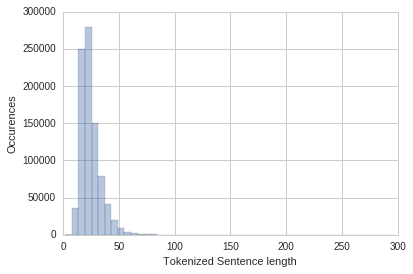

In [12]:
# Concatenate training and validation set for sequence length analysis
# and token id encoding later
X_all = pd.concat([X_train_sample, X_val], axis=0)

# Plot sequence length of questions, and determine outliers
sns.set_style('whitegrid')
seq_length = []
for row in X_all:
    seq_length.append(len(row.split(" ")))

sns.distplot(seq_length, kde=False)
plt.xlabel("Tokenized Sentence length")
plt.ylabel("Occurences")

print("seq length stats: ")
print("Max: ", max(seq_length))
print("Min: ", min(seq_length))
print("")
Q1 = np.percentile(seq_length, 25)
Q3 = np.percentile(seq_length, 75)
IQR = Q3 - Q1
print("Q1: ", Q1)
print("Mean: ", np.mean(seq_length))
print("Q3: ", Q3)
print("IQR: ", IQR)
print("Outlier range: < " + str(Q1 - 1.5*IQR) + " and > " + str(Q3 + 1.5*IQR))

In [13]:
# Build vocabulary
from tensorflow.contrib import learn

#max_document_length = max([len(x.split(" ")) for x in X_all])
max_document_length = 45
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
#x1 = np.array(list(vocab_processor.fit_transform(X_train_sample)))
#x2 = np.array(list(vocab_processor.fit_transform(X_val)))
vocab_processor.fit(X_train_sample)
vocab_processor.fit(X_val)
x1 = np.array(list(vocab_processor.transform(X_train_sample)))
x2 = np.array(list(vocab_processor.transform(X_val)))
print("Vocabulary size: {:d}".format(len(vocab_processor.vocabulary_)))

Vocabulary size: 87514


In [21]:
print(X_train_sample.iloc[0])
print(X_val.iloc[0])

what is difference between anti matter and dark matter \? how do atheists view marriage \?
how do i play pokémon go in korea \? how do i play pokémon go in china \?


In [22]:
print(x1[0])
print(x2[0])

[ 1  2  3  4  5  6  7  8  6  9 10 11 12 13  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[   9   10   16 1111 1968 1969  633   21 1797    9   10   16 1111 1968 1969
  633   21  395    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [23]:
# Check memory usage of x1
str(x1.nbytes / 1e6) + " MB"

'309.3642 MB'

In [ ]:
'''def build_vocabulary(df):
    '''
    Assigns an id to each unique word in dataset
    '''
    # Splits train dataset into tokens and calculates the unique number of tokens
    unique = [word for row in df for word in row.split()]
    token_count = set(unique)
    print("Vocabulary size: ", len(token_count))
    
    # Build vocabulary
    vocab = {}
    for i, u in enumerate(token_count):
        vocab[u] = i
    
    return vocab

vocab = build_vocabulary(X_all)'''

In [ ]:
'''def convert_token_to_token_id(df, vocabulary):
    '''
    Converts tokens in dataframe into ids, referencing from a vocabulary
    '''
    token_id = []
    for row in df:
        iid = []
        for word in row.split():
            iid.append(vocabulary.get(word))
        token_id.append(iid)
    return token_id

X_train_sample = convert_token_to_token_id(X_train_sample, vocab)
X_val = convert_token_to_token_id(X_val, vocab)

print(X_train_sample[:2])
print(X_val[:2])'''

In [ ]:
'''import joblib

with open('preprocess_train', 'wb'):  
    joblib.dump(x1, 'preprocess_train')
    
print("File saved.")'''

In [24]:
# Saves preprocessed data into a pickle file
import pickle

with open('preprocess_3.pickle', 'wb') as f:
    #pickle.dump(X_train_sample, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(x1, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(x2, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_train_sample, f, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(y_val, f, protocol=pickle.HIGHEST_PROTOCOL)
    
print("File saved.")

File saved.
